In [ ]:
# main.py

# Import necessary libraries
import os
import gc
import torch
import pandas as pd
from utils.dataUtils import DataUtils
from utils.modelUtils import ModelUtils
from utils.limeUtils import LIMEUtils
from utils.graphUtils import create_and_save_graph, draw_cluster_graph, draw_soi
from utils.soiUtils import SOIUtils
from utils.ragUtils import RAGUtils
from transformers import AutoTokenizer, AutoModelForCausalLM

# Parameters
dataset_name = 'manjuvallayil/factver_master'
model_name = 'MoritzLaurer/DeBERTa-v3-base-mnli-fever-anli'
embedding_model_name = 'sentence-transformers/all-mpnet-base-v2'
llama_model_name = 'meta-llama/Llama-2-7b-chat-hf'

selected_claim_id = 'Claim_50'
similarity_threshold = 0.75 # delta for cosine similarity
alpha = 0.5 # para for weighted vector combination of thematic embeddding (1 for RAG only) while retrieving the evidence doc
n_docs = 6 # number of docs to retrieve by RAG

# Paths for RAGUtils
passages_path = '/home/qsh5523/Documents/factver_dev/dataset'
index_path = '/home/qsh5523/Documents/factver_dev/faiss/index.faiss'

# Initialize LLaMA model
llama_tokenizer = AutoTokenizer.from_pretrained(llama_model_name)
llama_model = AutoModelForCausalLM.from_pretrained(llama_model_name)

# Initialize utilities
data_utils = DataUtils(dataset_name)
model_utils = ModelUtils(model_name, embedding_model_name)
lime_utils = LIMEUtils(model_utils)
soi_utils = SOIUtils(model_utils)
rag_utils = RAGUtils(passages_path, index_path, embedding_model_name)

# Function to generate LLM-based explanation
def generate_llm_summary(claim, evidences):
    # Clear the GPU cache first
    gc.collect()
    torch.cuda.empty_cache()
    combined_evidence = ' '.join([evidence for evidence in evidences])
    prompt = f"Claim: {claim}\nEvidence: {combined_evidence}\nYou are a fact verification assistant. From the given Claim and its Evidence, determine if the claim is supported by the evidence and generate a concise explanation (two sentences max)."
    
    with torch.no_grad():
        inputs = llama_tokenizer(prompt, return_tensors="pt", max_length=512, truncation=True)
        outputs = llama_model.generate(inputs['input_ids'], max_new_tokens=200)
    
    return llama_tokenizer.decode(outputs[0], skip_special_tokens=True).strip()

# Load themed data
theme, themed_data = data_utils.filter_by_theme(selected_claim_id)

# GMM-EM Clustering
# Check if themed data is available
if themed_data.empty:
    print("No data found for the specified theme.")
else:
    # Get embeddings
    all_texts = [row['Claim_text'] for _, row in themed_data.iterrows()]
    for _, row in themed_data.iterrows():
        all_texts.extend(row['Evidence_text'])

    embeddings = model_utils.get_sent_embeddings(all_texts)

    # Cluster embeddings within the selected theme
    labels = model_utils.cluster_embeddings(embeddings)
    unique_labels = set(labels)
    print(f"Unique clusters identified within the theme {theme}: {unique_labels}")
    
    graph_filepath = 'graph.pkl'
    create_and_save_graph(model_utils, themed_data, graph_filepath)

    # Draw cluster graph for the selected theme
    for cluster_id in unique_labels:
        draw_cluster_graph(themed_data, labels, cluster_id=cluster_id, model_utils=model_utils, title=f'{theme} - Cluster Visualization {cluster_id}')

    # Ensure the selected claim is in the identified cluster
    selected_cluster_id = None
    claim_text = None
    annotated_evidences = None

    for index, row in themed_data.iterrows():
        unique_id = row['Claim_topic_id'].split('_')[-1]
        if f"Claim_{unique_id}" == selected_claim_id:
            selected_cluster_id = labels[index]
            claim_text = row['Claim_text']
            annotated_evidences = row['Evidence_text']
            break

    
    # Annotated evidences explanation
    if claim_text is not None and annotated_evidences is not None:
        annotated_explanation = generate_llm_summary(claim_text, annotated_evidences)
        print("\nAnnotated Evidences based Explanation:\n", annotated_explanation)

    if selected_cluster_id is not None:
        print("\n")
        print(f"The selected claim ({selected_claim_id}) belongs to cluster {selected_cluster_id}")

        # Compare RAG (alpha=1.0) vs CARAG (alpha=0.5)

        # 1. RAG-based retrieval and explanation
        rag_evidence = rag_utils.retrieve_evidence(claim_text, n_docs, aggregated_embedding=None, alpha=1.0)
        rag_explanation = generate_llm_summary(claim_text, rag_evidence)
        print("\nRAG Explanation:\n", rag_explanation)
        
        # Compute the SOI
        soi = soi_utils.compute_soi(selected_claim_id, themed_data, labels, selected_cluster_id, similarity_threshold)
        soi_evidences = soi['related_claims'] + soi['annotated_evidences'] + soi['thematic_cluster_evidences']
        #print(f'SOI Evidences: {soi_evidences}')
        print("\n")
        draw_soi(soi, similarity_threshold, title=f'SOI Visualization for {selected_claim_id}')

        # Compute aggregated embedding for the SOI evidences
        aggregated_embedding = rag_utils.compute_aggregated_embedding([evidence for evidence, _ in soi_evidences])
        # Retrieve evidence using the aggregated embedding with CARAG (alpha=0.5)
        agg_evidence = rag_utils.retrieve_evidence(claim_text, n_docs, aggregated_embedding, alpha=0.5)

        
        # 2. Generate explanation using CARAG (retrieved evidence with combined embedding)
        carag_explanation = generate_llm_summary(claim_text, agg_evidence)
        print("\nCARAG Explanation:\n", carag_explanation)
    
    else:
        print(f"Selected claim {selected_claim_id} is not part of any identified cluster.")



Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

INFO:sentence_transformers.SentenceTransformer:Load pretrained SentenceTransformer: sentence-transformers/all-mpnet-base-v2
INFO:sentence_transformers.SentenceTransformer:Use pytorch device: cuda
INFO:root:Classification model loaded on CUDA
/home/qsh5523/miniconda3/envs/factver_env/lib/python3.10/site-packages/transformers/models/bart/configuration_bart.py:179: UserWarning:

Please make sure the config includes `forced_bos_token_id=0` in future versions. The config can simply be saved and uploaded again to be fixed.

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'RagTokenizer'. 
The class this function is called from is 'DPRQuestionEncoderTokenizer'.
The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class


 The selected Claim belongs to the theme: Climate


Batches:   0%|          | 0/20 [00:00<?, ?it/s]

Unique clusters identified within the theme Climate: {0, 1, 2}
Graph created with 638 nodes and 465 edges.
Cluster 0 graph has 209 nodes and 21092 edges after trimming outliers.
Cluster 1 graph has 142 nodes and 9618 edges after trimming outliers.
Cluster 2 graph has 287 nodes and 39547 edges after trimming outliers.

Annotated Evidences based Explanation:
 Claim: The united states led the world in electric vehicle exports in 2022
Evidence: India's plan is to maximise the use of electric vehicles; ensure that by 2025 the percentage of ethanol blended with petrol increases to 20% from the existing 10% and making a strong shift' of passenger and freight vehicles to public transport.
You are a fact verification assistant. From the given Claim and its Evidence, determine if the claim is supported by the evidence and generate a concise explanation (two sentences max).
The claim is supported by the evidence as India's plan to increase the use of electric vehicles and blend ethanol with petro

Batches:   0%|          | 0/5 [00:00<?, ?it/s]


CARAG Explanation:
 Claim: The united states led the world in electric vehicle exports in 2022
Evidence: They don't take into account the considerable amounts of emissions released in drilling, refining and transporting fuel such as petrol before it is put into a car. The programme aims to cut 17 percent of total emissions required in the next three years, and about a third of emissions reductions required by the end of the decade. The UK's carbon market is supposed to reduce carriers' emissions under the polluter pays principle. They could drive back to Israel and get a ferry around the middle east to Qatar - but that is a two-week journey which would have meant missing Wales' first match. That would leave Britain reliant on imports from other big producers such as China, the US and Europe, which have raced ahead with the help of big state subsidies. According to the Ministry, the customs tariffs on Battery Electric Vehicles (BEVs) imported under Completely Built-Up, Completely Knock

In [2]:
import numpy as np
import pandas as pd

# Load dataset and global vectors
dataset_vectors = rag_utils.load_dataset_vectors()  # Global context vectors
print(f"Loaded {len(dataset_vectors)} vectors from the FAISS index.")

# Load the data from the CSV file
data_path = 'results.csv'
df = pd.read_csv(data_path)

# Check for available themes in results.csv
themes = df['Theme'].unique() if 'Theme' in df.columns else []
print(f"Available themes in results.csv: {themes}")

# Step 1: Extract claim IDs and explanations
#df = df[df['Theme'] == 'Climate'] # Covid,Electric_Vehicles,Climate   @ select the theme here for theme based plots
claim_ids = df['Claim_id'].tolist()
annotated_explanations = df['Annotated'].tolist()
rag_explanations = df['RAG'].tolist()
carag_explanations = df['CARAG'].tolist()

# Define function for generating embeddings
def generate_explanation_embeddings(explanations, model_utils):
    explanation_embeddings = model_utils.get_sent_embeddings(explanations)
    return np.atleast_2d(explanation_embeddings)  # Ensure the embeddings are 2D

# Generate embeddings for explanations
annotated_embeddings = generate_explanation_embeddings(annotated_explanations, model_utils)
rag_embeddings = generate_explanation_embeddings(rag_explanations, model_utils)
carag_embeddings = generate_explanation_embeddings(carag_explanations, model_utils)

# Generate themed data embeddings for each theme
themed_data_embeddings = {}
for theme in themes:
    themed_data = data_utils.themed_data(theme)
    if not themed_data.empty:
        # Print a sample of themed_data for verification
        #print(f"Sample data for theme '{theme}':\n", themed_data.head())

        # Flatten list of lists in `Evidence_text`
        valid_evidence_texts = themed_data['Evidence_text'].dropna().tolist()
        valid_evidence_texts_flat = [item for sublist in valid_evidence_texts for item in sublist if isinstance(item, str) and item.strip()]
        
        # Generate embeddings if valid evidence texts exist
        if valid_evidence_texts_flat:
            themed_vectors = model_utils.get_sent_embeddings(valid_evidence_texts_flat)
            themed_data_embeddings[theme] = themed_vectors
            print(f"Generated embeddings for theme '{theme}' with {len(themed_vectors)} vectors.")
        else:
            print(f"No valid evidence texts found for theme '{theme}'.")
    else:
        print(f"No data found for theme '{theme}'")

Loaded 3102 vectors from the FAISS index.
Available themes in results.csv: ['Climate' 'Covid' 'Electric_Vehicles' nan]


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/16 [00:00<?, ?it/s]

Generated embeddings for theme 'Climate' with 486 vectors.


Batches:   0%|          | 0/63 [00:00<?, ?it/s]

Generated embeddings for theme 'Covid' with 2004 vectors.


Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Generated embeddings for theme 'Electric_Vehicles' with 606 vectors.
No data found for theme 'nan'


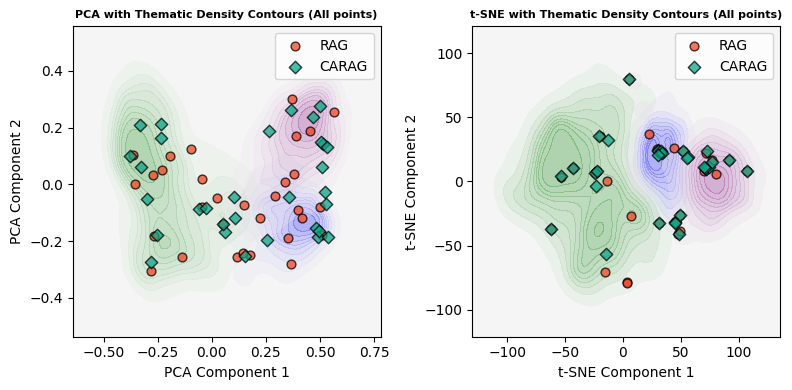

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Function to apply t-SNE
def apply_tsne(embeddings):
    n_samples = embeddings.shape[0]
    perplexity = min(30, n_samples - 1)  # Ensure perplexity is less than n_samples
    tsne = TSNE(n_components=2, perplexity=perplexity, random_state=42)
    return tsne.fit_transform(embeddings)

# Apply PCA and t-SNE transformations to RAG, CARAG, and themed embeddings
all_embeddings = np.vstack([rag_embeddings, carag_embeddings, *themed_data_embeddings.values()])
labels = ['RAG'] * len(rag_embeddings) + ['CARAG'] * len(carag_embeddings) + sum([[theme] * len(vectors) for theme, vectors in themed_data_embeddings.items()], [])

# PCA transformation
pca = PCA(n_components=2)
pca_embeddings = pca.fit_transform(all_embeddings)
rag_pca = pca_embeddings[:len(rag_embeddings)]
carag_pca = pca_embeddings[len(rag_embeddings):len(rag_embeddings) + len(carag_embeddings)]
themed_pca = {
    theme: pca_embeddings[len(rag_embeddings) + len(carag_embeddings) + sum(len(v) for k, v in list(themed_data_embeddings.items())[:i]):][:len(vectors)]
    for i, (theme, vectors) in enumerate(themed_data_embeddings.items())
}

# t-SNE transformation
tsne_embeddings = apply_tsne(all_embeddings)
rag_tsne = tsne_embeddings[:len(rag_embeddings)]
carag_tsne = tsne_embeddings[len(rag_embeddings):len(rag_embeddings) + len(carag_embeddings)]
themed_tsne = {
    theme: tsne_embeddings[len(rag_embeddings) + len(carag_embeddings) + sum(len(v) for k, v in list(themed_data_embeddings.items())[:i]):][:len(vectors)]
    for i, (theme, vectors) in enumerate(themed_data_embeddings.items())
}

# Define distinct colors for each theme
theme_colors = {
    'Climate': 'blue',
    'Covid': 'green',
    'Electric_Vehicles': 'purple' 
}

# Plotting side by side
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

# PCA plot with separate thematic densities
for theme, color in theme_colors.items():
    sns.kdeplot(x=themed_pca[theme][:, 0], y=themed_pca[theme][:, 1], ax=axes[0], fill=True, cmap=sns.light_palette(color, as_cmap=True), alpha=0.3, label=f'{theme} Contour')
axes[0].scatter(rag_pca[:, 0], rag_pca[:, 1], color="#F24726", edgecolor='black', label='RAG', s=40, alpha=0.75)
axes[0].scatter(carag_pca[:, 0], carag_pca[:, 1], color="#0CA789", edgecolor='black', label='CARAG', s=40, marker='D', alpha=0.75)
axes[0].set_title("PCA with Thematic Density Contours (All points)", fontsize=8, fontweight='bold')
axes[0].set_xlabel("PCA Component 1")
axes[0].set_ylabel("PCA Component 2")
axes[0].set_facecolor('#f5f5f5')


# t-SNE plot with separate thematic densities
for theme, color in theme_colors.items():
    sns.kdeplot(x=themed_tsne[theme][:, 0], y=themed_tsne[theme][:, 1], ax=axes[1], fill=True, cmap=sns.light_palette(color, as_cmap=True), alpha=0.3, label=f'{theme} Contour')
axes[1].scatter(rag_tsne[:, 0], rag_tsne[:, 1], color="#F24726", edgecolor='black', label='RAG', s=40, alpha=0.75)
axes[1].scatter(carag_tsne[:, 0], carag_tsne[:, 1], color="#0CA789", edgecolor='black', label='CARAG', s=40, marker='D', alpha=0.75)
axes[1].set_title("t-SNE with Thematic Density Contours (All points)", fontsize=8, fontweight='bold')
axes[1].set_xlabel("t-SNE Component 1")
axes[1].set_ylabel("t-SNE Component 2")
axes[1].set_facecolor('#f5f5f5')

# Legends and layout
axes[0].legend(title='', loc='upper right')
axes[1].legend(title='', loc='upper right')
plt.tight_layout()
plt.show()

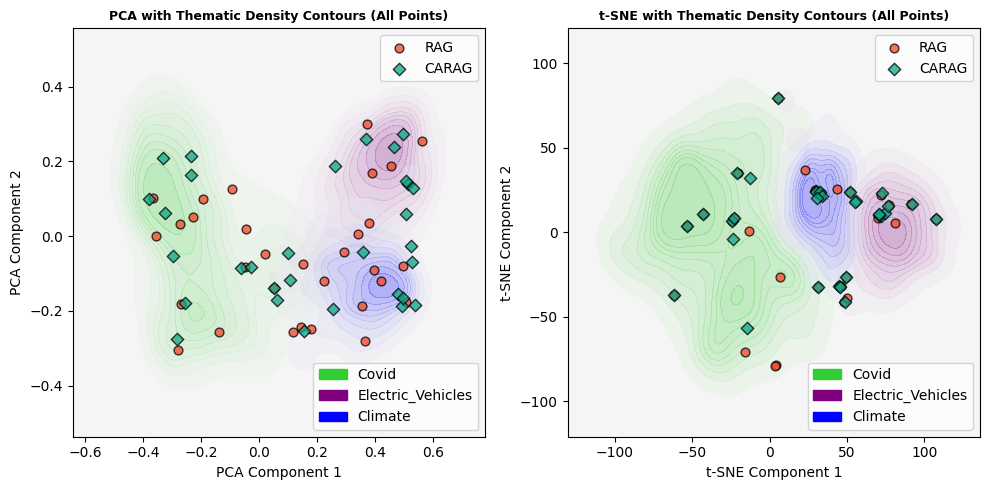

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.patches as mpatches

# Function to apply t-SNE
def apply_tsne(embeddings):
    n_samples = embeddings.shape[0]
    perplexity = min(30, n_samples - 1)  # Ensure perplexity is less than n_samples
    tsne = TSNE(n_components=2, perplexity=perplexity, random_state=42)
    return tsne.fit_transform(embeddings)

# Apply PCA and t-SNE transformations to RAG, CARAG, and themed embeddings
all_embeddings = np.vstack([rag_embeddings, carag_embeddings, *themed_data_embeddings.values()])
labels = ['RAG'] * len(rag_embeddings) + ['CARAG'] * len(carag_embeddings) + sum([[theme] * len(vectors) for theme, vectors in themed_data_embeddings.items()], [])

# PCA transformation
pca = PCA(n_components=2)
pca_embeddings = pca.fit_transform(all_embeddings)
rag_pca = pca_embeddings[:len(rag_embeddings)]
carag_pca = pca_embeddings[len(rag_embeddings):len(rag_embeddings) + len(carag_embeddings)]
themed_pca = {
    theme: pca_embeddings[len(rag_embeddings) + len(carag_embeddings) + sum(len(v) for k, v in list(themed_data_embeddings.items())[:i]):][:len(vectors)]
    for i, (theme, vectors) in enumerate(themed_data_embeddings.items())
}

# t-SNE transformation
tsne_embeddings = apply_tsne(all_embeddings)
rag_tsne = tsne_embeddings[:len(rag_embeddings)]
carag_tsne = tsne_embeddings[len(rag_embeddings):len(rag_embeddings) + len(carag_embeddings)]
themed_tsne = {
    theme: tsne_embeddings[len(rag_embeddings) + len(carag_embeddings) + sum(len(v) for k, v in list(themed_data_embeddings.items())[:i]):][:len(vectors)]
    for i, (theme, vectors) in enumerate(themed_data_embeddings.items())
}

# Define distinct colors for each theme
theme_colors = {
    'Covid': '#32CD32',
    'Electric_Vehicles': 'purple',
    'Climate': 'blue'    
}

# Plotting side by side
fig, axes = plt.subplots(1, 2, figsize=(10, 5)) #figsize=(8, 4.25)

# PCA plot with separate thematic densities
for theme, color in theme_colors.items():
    sns.kdeplot(x=themed_pca[theme][:, 0], y=themed_pca[theme][:, 1], ax=axes[0], fill=True, cmap=sns.light_palette(color, as_cmap=True), alpha=0.3, label=f'{theme} Contour')
axes[0].scatter(rag_pca[:, 0], rag_pca[:, 1], color="#F24726", edgecolor='black', label='RAG', s=40, alpha=0.75)
axes[0].scatter(carag_pca[:, 0], carag_pca[:, 1], color="#0CA789", edgecolor='black', label='CARAG', s=40, marker='D', alpha=0.75)
axes[0].set_title("PCA with Thematic Density Contours (All Points)", fontsize=9, fontweight='bold')
axes[0].set_xlabel("PCA Component 1")
axes[0].set_ylabel("PCA Component 2")
axes[0].set_facecolor('#f5f5f5')


# t-SNE plot with separate thematic densities
for theme, color in theme_colors.items():
    sns.kdeplot(x=themed_tsne[theme][:, 0], y=themed_tsne[theme][:, 1], ax=axes[1], fill=True, cmap=sns.light_palette(color, as_cmap=True), alpha=0.3, label=f'{theme} Contour')
axes[1].scatter(rag_tsne[:, 0], rag_tsne[:, 1], color="#F24726", edgecolor='black', label='RAG', s=40, alpha=0.75)
axes[1].scatter(carag_tsne[:, 0], carag_tsne[:, 1], color="#0CA789", edgecolor='black', label='CARAG', s=40, marker='D', alpha=0.75)
axes[1].set_title("t-SNE with Thematic Density Contours (All Points)", fontsize=9, fontweight='bold')
axes[1].set_xlabel("t-SNE Component 1")
axes[1].set_ylabel("t-SNE Component 2")
axes[1].set_facecolor('#f5f5f5')

# Add the first legend for scatter plot points (RAG and CARAG)
handles_points, labels_points = axes[0].get_legend_handles_labels()
legend_points = axes[0].legend(handles=handles_points, labels=labels_points, loc='upper right') #title='Legend (Points)'


# Add the second legend for thematic colors
theme_legend_patches = [mpatches.Patch(color=color, label=f"{theme}") for theme, color in theme_colors.items()]
legend_theme = axes[0].legend(handles=theme_legend_patches, loc='lower right') #title='Legend (Themes)'

# Add the first legend back manually
axes[0].add_artist(legend_points)

# Repeat for the second plot (t-SNE)
handles_points_tsne, labels_points_tsne = axes[1].get_legend_handles_labels()
legend_points_tsne = axes[1].legend(handles=handles_points_tsne, labels=labels_points_tsne, loc='upper right') #title='Legend (Points)'

legend_theme_tsne = axes[1].legend(handles=theme_legend_patches, loc='lower right') #title='Legend (Themes)'

axes[1].add_artist(legend_points_tsne)

# Layout and show the plot
plt.tight_layout()
plt.show()

In [7]:
import numpy as np
import pandas as pd
from scipy.spatial.distance import cdist
from IPython.display import display

# Load the data from results.csv
data_path = 'results.csv'
df = pd.read_csv(data_path)

# Check for available themes and exclude `nan`
themes = [theme for theme in df['Theme'].unique() if pd.notna(theme)]
print(f"Available themes in results.csv (excluding nan): {themes}")

# Filter RAG and CARAG points by theme from the CSV file
rag_points = {theme: rag_pca[np.array(df[df['Theme'] == theme].index)] for theme in themes}
carag_points = {theme: carag_pca[np.array(df[df['Theme'] == theme].index)] for theme in themes}

# Step 1: Calculate the centroids of each theme contour
theme_centroids_pca = {theme: np.mean(themed_pca[theme], axis=0) for theme in themes}
theme_centroids_tsne = {theme: np.mean(themed_tsne[theme], axis=0) for theme in themes}

# Step 2: Calculate distances of RAG points to theme centroids (PCA and t-SNE)
rag_distances_pca = {theme: cdist(rag_points[theme], [theme_centroids_pca[theme]]).flatten() for theme in themes}
rag_distances_tsne = {theme: cdist(rag_points[theme], [theme_centroids_tsne[theme]]).flatten() for theme in themes}

# Step 3: Calculate distances of CARAG points to theme centroids (PCA and t-SNE)
carag_distances_pca = {theme: cdist(carag_points[theme], [theme_centroids_pca[theme]]).flatten() for theme in themes}
carag_distances_tsne = {theme: cdist(carag_points[theme], [theme_centroids_tsne[theme]]).flatten() for theme in themes}

# Step 4: Prepare DataFrames for RAG and CARAG distances with difference column
theme_tables = {}
for theme in themes:
    theme_table = []
    for i in range(len(rag_distances_pca[theme])):
        theme_table.append({
            "Theme": theme,
            "Point Index": i,
            "RAG Distance (PCA)": rag_distances_pca[theme][i],
            "CARAG Distance (PCA)": carag_distances_pca[theme][i],
            "Difference (PCA)": carag_distances_pca[theme][i] - rag_distances_pca[theme][i],
            "RAG Distance (t-SNE)": rag_distances_tsne[theme][i],
            "CARAG Distance (t-SNE)": carag_distances_tsne[theme][i],
            "Difference (t-SNE)": carag_distances_tsne[theme][i] - rag_distances_tsne[theme][i]
        })
    theme_tables[theme] = pd.DataFrame(theme_table)

# Display theme-specific tables
for theme, table in theme_tables.items():
    print(f"\nEuclidean Distance Table for Theme: {theme}")
    display(table)

# Step 5: Prepare a combined alignment comparison table
alignment_comparison = []
for theme in themes:
    rag_avg_distance_pca = np.mean(rag_distances_pca[theme])
    carag_avg_distance_pca = np.mean(carag_distances_pca[theme])
    rag_avg_distance_tsne = np.mean(rag_distances_tsne[theme])
    carag_avg_distance_tsne = np.mean(carag_distances_tsne[theme])

    alignment_comparison.append({
        "Theme": theme,
        "RAG Avg Distance (PCA)": rag_avg_distance_pca,
        "CARAG Avg Distance (PCA)": carag_avg_distance_pca,
        "Difference (PCA)": carag_avg_distance_pca - rag_avg_distance_pca,
        "RAG Avg Distance (t-SNE)": rag_avg_distance_tsne,
        "CARAG Avg Distance (t-SNE)": carag_avg_distance_tsne,
        "Difference (t-SNE)": carag_avg_distance_tsne - rag_avg_distance_tsne,
        "Better Alignment (PCA)": "CARAG" if carag_avg_distance_pca < rag_avg_distance_pca else "RAG",
        "Better Alignment (t-SNE)": "CARAG" if carag_avg_distance_tsne < rag_avg_distance_tsne else "RAG"
    })

# Convert alignment comparison to a DataFrame
alignment_df = pd.DataFrame(alignment_comparison)

# Display the combined alignment comparison table
print("\nCombined Alignment Comparison Table:")
display(alignment_df)

# Optionally save all tables
for theme, table in theme_tables.items():
    filename = f"euclidean_distance_table_{theme}.csv"
    table.to_csv(filename, index=False)
    print(f"Saved table for theme '{theme}' as '{filename}'.")

alignment_df.to_csv("alignment_comparison.csv", index=False)
print("Saved combined alignment comparison table as 'alignment_comparison.csv'.")

Available themes in results.csv (excluding nan): ['Climate', 'Covid', 'Electric_Vehicles']

Euclidean Distance Table for Theme: Climate


,Theme,Point Index,RAG Distance (PCA),CARAG Distance (PCA),Difference (PCA),RAG Distance (t-SNE),CARAG Distance (t-SNE),Difference (t-SNE)
0,Climate,0,0.059003,0.662552,0.603550,37.331571,37.860293,0.528721
1,Climate,1,0.217964,0.123394,-0.094571,37.516351,37.202447,-0.313904
2,Climate,2,0.053067,0.144162,0.091095,37.250475,37.206111,-0.044363
3,Climate,3,0.151726,0.253357,0.101631,37.360950,37.523214,0.162263
4,Climate,4,0.155147,0.139705,-0.015443,37.189073,37.195016,0.005943
5,Climate,5,0.136763,0.085626,-0.051137,37.419142,37.265316,-0.153825
6,Climate,6,0.274883,0.187808,-0.087074,37.575031,37.163589,-0.411442
7,Climate,7,0.347311,0.192988,-0.154322,37.568937,37.108234,-0.460703
8,Climate,8,0.146108,0.178921,0.032813,37.155137,37.122285,-0.032852
9,Climate,9,0.514266,0.125163,-0.389103,37.804385,37.424696,-0.379690



Euclidean Distance Table for Theme: Covid


,Theme,Point Index,RAG Distance (PCA),CARAG Distance (PCA),Difference (PCA),RAG Distance (t-SNE),CARAG Distance (t-SNE),Difference (t-SNE)
0,Covid,0,0.113399,0.226417,0.113017,31.585083,31.560845,-0.024238
1,Covid,1,0.142300,0.250524,0.108224,31.412046,31.466465,0.054420
2,Covid,2,0.299875,0.271991,-0.027884,31.441921,31.444441,0.002520
3,Covid,3,0.191294,0.199567,0.008274,31.415813,31.403055,-0.012758
4,Covid,4,0.064570,0.135435,0.070864,31.544008,31.449226,-0.094782
5,Covid,5,0.177892,0.173573,-0.004318,31.471168,31.484333,0.013165
6,Covid,6,0.181048,0.176835,-0.004213,31.687811,31.555816,-0.131995
7,Covid,7,0.640466,0.168717,-0.471749,32.159829,31.689488,-0.470341
8,Covid,8,0.368748,0.199404,-0.169343,31.901131,31.724237,-0.176893
9,Covid,9,0.552367,0.317740,-0.234627,32.099227,31.800492,-0.298735



Euclidean Distance Table for Theme: Electric_Vehicles


,Theme,Point Index,RAG Distance (PCA),CARAG Distance (PCA),Difference (PCA),RAG Distance (t-SNE),CARAG Distance (t-SNE),Difference (t-SNE)
0,Electric_Vehicles,0,0.198934,0.115518,-0.083416,76.122644,76.174841,0.052197
1,Electric_Vehicles,1,0.679574,0.140499,-0.539075,76.962115,76.423655,-0.538460
2,Electric_Vehicles,2,0.498380,0.109293,-0.389087,76.738309,76.180875,-0.557434
3,Electric_Vehicles,3,0.111157,0.133839,0.022682,76.311447,76.157454,-0.153993
4,Electric_Vehicles,4,0.462753,0.466857,0.004104,76.550443,76.540904,-0.009539
5,Electric_Vehicles,5,0.026079,0.164287,0.138208,76.297911,76.187115,-0.110796
6,Electric_Vehicles,6,0.156484,0.118804,-0.037680,76.311968,76.317858,0.005890
7,Electric_Vehicles,7,0.215109,0.140265,-0.074844,76.398621,76.180788,-0.217833
8,Electric_Vehicles,8,0.460725,0.352218,-0.108507,76.735371,76.590100,-0.145271
9,Electric_Vehicles,9,0.071837,0.115987,0.044150,76.231775,76.219864,-0.011912



Combined Alignment Comparison Table:


,Theme,RAG Avg Distance (PCA),CARAG Avg Distance (PCA),Difference (PCA),RAG Avg Distance (t-SNE),CARAG Avg Distance (t-SNE),Difference (t-SNE),Better Alignment (PCA),Better Alignment (t-SNE)
0,Climate,0.205624,0.209368,0.003744,37.417105,37.307120,-0.109985,RAG,CARAG
1,Covid,0.273196,0.212020,-0.061176,31.671804,31.557840,-0.113964,CARAG,CARAG
2,Electric_Vehicles,0.288103,0.185757,-0.102346,76.466060,76.297345,-0.168715,CARAG,CARAG


Saved table for theme 'Climate' as 'euclidean_distance_table_Climate.csv'.
Saved table for theme 'Covid' as 'euclidean_distance_table_Covid.csv'.
Saved table for theme 'Electric_Vehicles' as 'euclidean_distance_table_Electric_Vehicles.csv'.
Saved combined alignment comparison table as 'alignment_comparison.csv'.


In [10]:
import numpy as np
import pandas as pd
from scipy.spatial.distance import cdist
from IPython.display import display

# Load the data from results.csv
data_path = 'results.csv'
df = pd.read_csv(data_path)

# Check for available themes and exclude `nan`
themes = [theme for theme in df['Theme'].unique() if pd.notna(theme)]
print(f"Available themes in results.csv (excluding nan): {themes}")

# Filter RAG and CARAG points by theme from the CSV file
rag_points = {theme: rag_pca[np.array(df[df['Theme'] == theme].index)] for theme in themes}
carag_points = {theme: carag_pca[np.array(df[df['Theme'] == theme].index)] for theme in themes}

# Step 1: Calculate the centroids of each theme contour
theme_centroids_pca = {theme: np.mean(themed_pca[theme], axis=0) for theme in themes}
theme_centroids_tsne = {theme: np.mean(themed_tsne[theme], axis=0) for theme in themes}

# Step 2: Calculate distances of RAG points to theme centroids (PCA and t-SNE)
rag_distances_pca = {theme: cdist(rag_points[theme], [theme_centroids_pca[theme]]).flatten() for theme in themes}
rag_distances_tsne = {theme: cdist(rag_points[theme], [theme_centroids_tsne[theme]]).flatten() for theme in themes}

# Step 3: Calculate distances of CARAG points to theme centroids (PCA and t-SNE)
carag_distances_pca = {theme: cdist(carag_points[theme], [theme_centroids_pca[theme]]).flatten() for theme in themes}
carag_distances_tsne = {theme: cdist(carag_points[theme], [theme_centroids_tsne[theme]]).flatten() for theme in themes}

# Step 4: Combine all data into a single table
combined_data = []
for theme in themes:
    for i in range(len(rag_distances_pca[theme])):
        combined_data.append({
            "Theme": theme,
            "Point Index": i,
            "RAG Distance (PCA)": rag_distances_pca[theme][i],
            "CARAG Distance (PCA)": carag_distances_pca[theme][i],
            "Difference (PCA)": carag_distances_pca[theme][i] - rag_distances_pca[theme][i],
            "RAG Distance (t-SNE)": rag_distances_tsne[theme][i],
            "CARAG Distance (t-SNE)": carag_distances_tsne[theme][i],
            "Difference (t-SNE)": carag_distances_tsne[theme][i] - rag_distances_tsne[theme][i]
        })
    # Add average row for the current theme
    combined_data.append({
        "Theme": f"Average ({theme})",
        "Point Index": "Average",
        "RAG Distance (PCA)": np.mean(rag_distances_pca[theme]),
        "CARAG Distance (PCA)": np.mean(carag_distances_pca[theme]),
        "Difference (PCA)": np.mean(carag_distances_pca[theme]) - np.mean(rag_distances_pca[theme]),
        "RAG Distance (t-SNE)": np.mean(rag_distances_tsne[theme]),
        "CARAG Distance (t-SNE)": np.mean(carag_distances_tsne[theme]),
        "Difference (t-SNE)": np.mean(carag_distances_tsne[theme]) - np.mean(rag_distances_tsne[theme])
    })

# Add an overall average row
overall_avg = pd.DataFrame(combined_data).iloc[:, 2:].mean(axis=0).to_dict()
overall_avg.update({"Theme": "Overall Average", "Point Index": "Overall"})
combined_data.append(overall_avg)

# Convert combined data to a DataFrame
final_table = pd.DataFrame(combined_data)

# Display the final table
styled_final_table = final_table.style.format(precision=4).applymap(
    lambda x: 'font-weight: bold;' if isinstance(x, float) and (x == final_table["RAG Distance (PCA)"].min() or x == final_table["CARAG Distance (PCA)"].min()) else '',
    subset=["RAG Distance (PCA)", "CARAG Distance (PCA)"]
).applymap(
    lambda x: 'font-weight: bold;' if isinstance(x, float) and (x == final_table["RAG Distance (t-SNE)"].min() or x == final_table["CARAG Distance (t-SNE)"].min()) else '',
    subset=["RAG Distance (t-SNE)", "CARAG Distance (t-SNE)"]
)

# Display styled table
display(styled_final_table)

# Save the final table
final_table.to_csv("final_combined_table.csv", index=False)
print("Final combined table saved as 'final_combined_table.csv'.")

Available themes in results.csv (excluding nan): ['Climate', 'Covid', 'Electric_Vehicles']


/tmp/ipykernel_902807/2114378439.py:65: FutureWarning:

Styler.applymap has been deprecated. Use Styler.map instead.



,Theme,Point Index,RAG Distance (PCA),CARAG Distance (PCA),Difference (PCA),RAG Distance (t-SNE),CARAG Distance (t-SNE),Difference (t-SNE)
0,Climate,0,0.0590,0.6626,0.6035,37.3316,37.8603,0.5287
1,Climate,1,0.2180,0.1234,-0.0946,37.5164,37.2024,-0.3139
2,Climate,2,0.0531,0.1442,0.0911,37.2505,37.2061,-0.0444
3,Climate,3,0.1517,0.2534,0.1016,37.3610,37.5232,0.1623
4,Climate,4,0.1551,0.1397,-0.0154,37.1891,37.1950,0.0059
5,Climate,5,0.1368,0.0856,-0.0511,37.4191,37.2653,-0.1538
6,Climate,6,0.2749,0.1878,-0.0871,37.5750,37.1636,-0.4114
7,Climate,7,0.3473,0.1930,-0.1543,37.5689,37.1082,-0.4607
8,Climate,8,0.1461,0.1789,0.0328,37.1551,37.1223,-0.0329
9,Climate,9,0.5143,0.1252,-0.3891,37.8044,37.4247,-0.3797


Final combined table saved as 'final_combined_table.csv'.


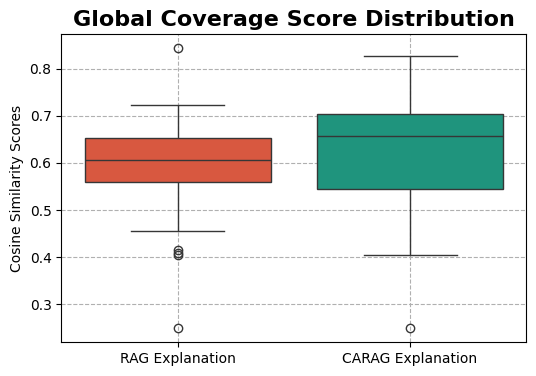

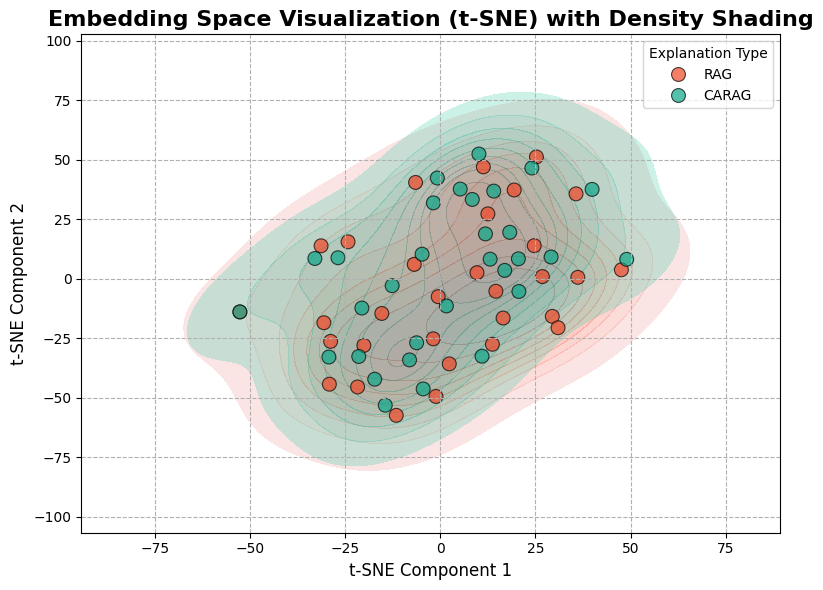

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity

# Function to compute Global Coverage Scores
def compute_global_coverage(explanation_embeddings, dataset_vectors, top_k=10):
    scores = []
    for explanation_embedding in explanation_embeddings:
        explanation_embedding = explanation_embedding.reshape(1, -1)
        similarities = cosine_similarity(explanation_embedding, dataset_vectors)[0]
        top_k_similarities = np.sort(similarities)[-top_k:]
        scores.append(np.mean(top_k_similarities))
    return scores

# Function to visualize Global Coverage Scores using boxplot
def visualize_global_coverage(rag_scores, carag_scores):
    data = {
        "RAG Explanation": rag_scores,
        "CARAG Explanation": carag_scores
    }
    df = pd.DataFrame.from_dict(data, orient='index').transpose()

    plt.figure(figsize=(6, 4))
    sns.boxplot(data=df, palette=["#F24726", "#0CA789"])
    plt.title("Global Coverage Score Distribution", fontsize=16, fontweight='bold')
    plt.ylabel("Cosine Similarity Scores")
    plt.grid(True, linestyle='--')
    plt.show()

# Function to visualize embedding space with t-SNE and density shading
def visualize_embedding_space_with_tsne(rag_embeddings, carag_embeddings):
    all_embeddings = np.vstack([rag_embeddings, carag_embeddings])
    labels = ['RAG'] * len(rag_embeddings) + ['CARAG'] * len(carag_embeddings)

    # Perform t-SNE
    tsne = TSNE(n_components=2, random_state=42, perplexity=15)
    reduced_embeddings = tsne.fit_transform(all_embeddings)

    # Convert to DataFrame for easy plotting
    tsne_df = pd.DataFrame(reduced_embeddings, columns=['Component 1', 'Component 2'])
    tsne_df['Label'] = labels

    # Plot with density shading
    plt.figure(figsize=(8, 6))
    sns.kdeplot(
        data=tsne_df[tsne_df['Label'] == 'RAG'], x="Component 1", y="Component 2", 
        fill=True, color="#F24726", alpha=0.3, label="RAG"
    )
    sns.kdeplot(
        data=tsne_df[tsne_df['Label'] == 'CARAG'], x="Component 1", y="Component 2", 
        fill=True, color="#0CA789", alpha=0.3, label="CARAG"
    )

    # Scatter plot overlaid with density shading
    sns.scatterplot(
        data=tsne_df, x="Component 1", y="Component 2", hue="Label", 
        palette={"RAG": "#F24726", "CARAG": "#0CA789"}, edgecolor='black', s=100, alpha=0.7
    )

    # Adjust legend and titles
    plt.legend(title='Explanation Type')
    plt.title("Embedding Space Visualization (t-SNE) with Density Shading", fontsize=16, fontweight='bold')
    plt.xlabel("t-SNE Component 1", fontsize=12)
    plt.ylabel("t-SNE Component 2", fontsize=12)
    plt.grid(True, linestyle='--')
    plt.tight_layout()
    plt.show()

# Compute Global Coverage Scores
rag_scores = compute_global_coverage(rag_embeddings, dataset_vectors, top_k=10)
carag_scores = compute_global_coverage(carag_embeddings, dataset_vectors, top_k=10)

# Visualize Global Coverage and Embedding Space
visualize_global_coverage(rag_scores, carag_scores)
visualize_embedding_space_with_tsne(rag_embeddings, carag_embeddings)